In [2]:
import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

Calculated sample standard deviation: 16053.682068781582

CI based on T-score: [169603.20535178584, 192226.03394466816]

CI based on Z-score: [170964.62725179936, 190864.61204465464]

Mean: 180914.619648227
[176122.50988647, 176122.50988647, 176122.50988647, 176122.50988647, 226549.20436232, 176122.50988647, 176122.50988647, 176122.50988647, 173616.91302819, 176122.50988647]

Calculated sample standard deviation: 24187.418633604295

CI based on T-score: [671220.6646460664, 705305.5445825137]

CI based on Z-score: [673271.8627009114, 703254.3465276688]

Mean: 688263.1046142901

Calculated sample standard deviation: 17836.177197354136

CI based on T-score: [772384.3685384274, 797519.0870260126]

CI based on Z-score: [773896.953759996, 796006.501804444]

Mean: 784951.72778222


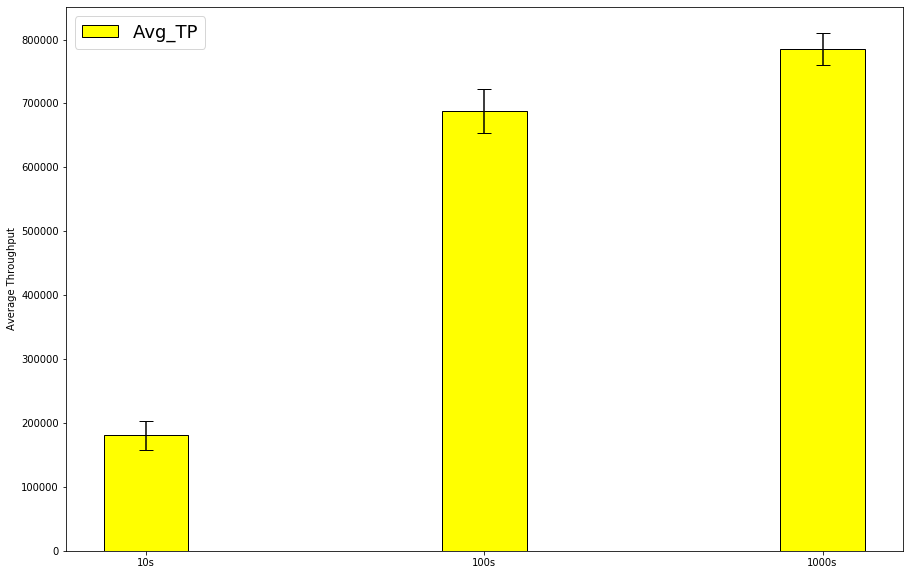

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats

cols = ['run', 'ber', 'timelimit', 'repetition', 'Module', 'Avg_Throughput']
data = pd.read_csv('Ten_Runs_avg-throughput_scalar.csv',
    delimiter=',', skiprows=[0], names=cols)

df = pd.DataFrame(data)

con_coef = 0.95

avgTP_10s_arr = []
avgTP_100s_arr = []
avgTP_1000s_arr = []

for i in range(len(data)):
    if (df['timelimit'][i] == 10):
        avgTP_10s_arr.append(df['Avg_Throughput'][i])
    elif (df['timelimit'][i] == 100):
        avgTP_100s_arr.append(df['Avg_Throughput'][i])
    elif (df['timelimit'][i] == 1000):
        avgTP_1000s_arr.append(df['Avg_Throughput'][i])


# Sample variance = SUM((x_i - x_bar)^2) / (n - 1)
# Sample standard deviation = sqrt(sample variance)

def sampleStdDev(arr):
    sampleVariance = 0
    for i, val in enumerate(arr):
        sampleVariance += (val - sampleMean(arr))**2
    
    sampleVariance = sampleVariance / (len(arr) - 1)
    return math.sqrt(sampleVariance)

def sampleMean(arr):
    return statistics.mean(arr)


# We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.

def tScore(conf, arr):
    return stats.t.ppf((conf + 1) / 2, len(arr))

def confInterval_t(conf, arr):
    CI_bounds = []
    CI_bounds.append(sampleMean(arr) - tScore(conf, arr) * sampleStdDev(arr) / math.sqrt(len(arr)))
    CI_bounds.append(sampleMean(arr) + tScore(conf, arr) * sampleStdDev(arr) / math.sqrt(len(arr)))
    return CI_bounds

def confInterval_z(a, b, arr):
    CI_bounds = []
    CI_bounds.append(sampleMean(arr) + a * sampleStdDev(arr) / math.sqrt(len(arr)))
    CI_bounds.append(sampleMean(arr) + b * sampleStdDev(arr) / math.sqrt(len(arr)))
    return CI_bounds

print(f"Calculated sample standard deviation: {sampleStdDev(avgTP_10s_arr)}")
print(f"\nCI based on T-score:", confInterval_t(con_coef, avgTP_10s_arr))
print(f"\nCI based on Z-score:", confInterval_z(z_interval_l, z_interval_r, avgTP_10s_arr))
print(f"\nMean: {sampleMean(avgTP_10s_arr)}")
print(avgTP_10s_arr)

print(f"\nCalculated sample standard deviation: {sampleStdDev(avgTP_100s_arr)}")
print(f"\nCI based on T-score:", confInterval_t(con_coef, avgTP_100s_arr))
print(f"\nCI based on Z-score:", confInterval_z(z_interval_l, z_interval_r, avgTP_100s_arr))
print(f"\nMean: {sampleMean(avgTP_100s_arr)}")

print(f"\nCalculated sample standard deviation: {sampleStdDev(avgTP_1000s_arr)}")
print(f"\nCI based on T-score:", confInterval_t(con_coef, avgTP_1000s_arr))
print(f"\nCI based on Z-score:", confInterval_z(z_interval_l, z_interval_r, avgTP_1000s_arr))
print(f"\nMean: {sampleMean(avgTP_1000s_arr)}")

CI_10s = confInterval_t(con_coef, avgTP_10s_arr)
CI_100s = confInterval_t(con_coef, avgTP_100s_arr)
CI_1000s = confInterval_t(con_coef, avgTP_1000s_arr)


# width of the bars
barWidth = 0.25

# Choose the height of the blue bars
bars = [sampleMean(avgTP_10s_arr), sampleMean(avgTP_100s_arr), sampleMean(avgTP_1000s_arr)]
 
# Choose the height of the error bars (bars1)
yer = [CI_10s[1] - CI_10s[0], CI_100s[1] - CI_100s[0], CI_1000s[1] - CI_1000s[0]]
 
# The x position of bars
r = np.arange(len(bars))
#r2 = [x + barWidth for x in r1]

plt.figure(figsize = (15,10))
# Create blue bars
plt.bar(r, bars, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=yer, capsize=7, label=True)
 
# Create cyan bars
#plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='sorgho')
 
# general layout
plt.xticks(np.arange(len(bars)), ['10s', '100s', '1000s'])
plt.ylabel('Average Throughput')
plt.legend(['Avg_TP'], loc = 'upper left', fontsize = 18)

# Show graphic
plt.show()

Calculated sample standard deviation: 70076.78607071172

CI based on T-score: [185663.13362680096, 237921.66782711237]

CI based on Z-score: [186716.20567730916, 236868.59577660417]

Mean: 211792.40072695666

Calculated sample standard deviation: 41045.30883296226

CI based on T-score: [677651.8962776476, 708260.7154841291]

CI based on Z-score: [678268.7006426888, 707643.911119088]

Mean: 692956.3058808884

Calculated sample standard deviation: 16001.192281077303

CI based on T-score: [770565.5233136389, 782498.1318271438]

CI based on Z-score: [770805.9796660322, 782257.6754747505]

Mean: 776531.8275703914


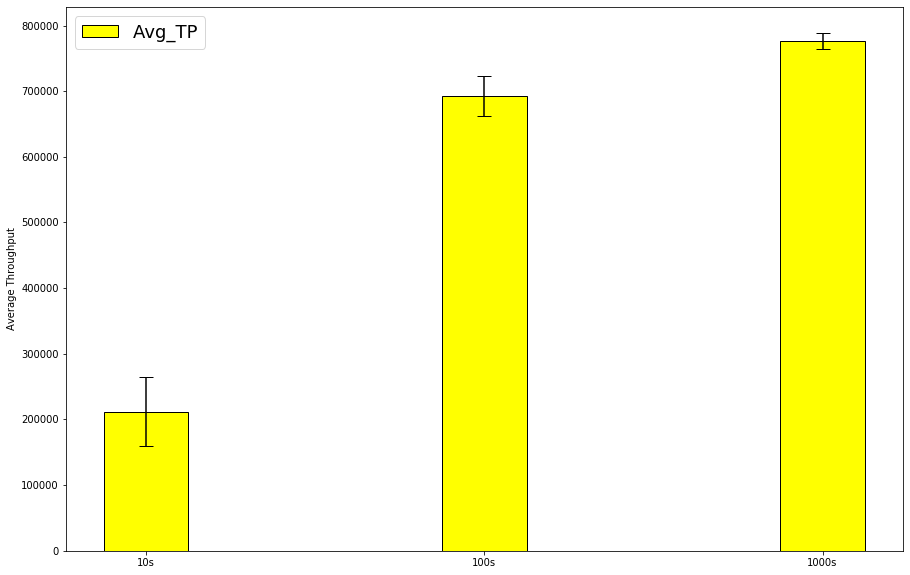

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats

cols = ['run', 'ber', 'timelimit', 'repetition', 'Module', 'Avg_Throughput']
data = pd.read_csv('Thirty_Runs_avg-throughput_scalar.csv',
    delimiter=',', skiprows=[0], names=cols)

df = pd.DataFrame(data)

con_coef = 0.95

avgTP_10s_arr = []
avgTP_100s_arr = []
avgTP_1000s_arr = []

for i in range(len(data)):
    if (df['timelimit'][i] == 10):
        avgTP_10s_arr.append(df['Avg_Throughput'][i])
    elif (df['timelimit'][i] == 100):
        avgTP_100s_arr.append(df['Avg_Throughput'][i])
    elif (df['timelimit'][i] == 1000):
        avgTP_1000s_arr.append(df['Avg_Throughput'][i])


# Sample variance = SUM((x_i - x_bar)^2) / (n - 1)
# Sample standard deviation = sqrt(sample variance)

def sampleStdDev(arr):
    sampleVariance = 0
    for i, val in enumerate(arr):
        sampleVariance += (val - sampleMean(arr))**2
    
    sampleVariance = sampleVariance / (len(arr) - 1)
    return math.sqrt(sampleVariance)

def sampleMean(arr):
    return statistics.mean(arr)

# We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.

def tScore(conf, arr):
    return stats.t.ppf((conf + 1) / 2, len(arr))

def confInterval_t(conf, arr):
    CI_bounds = []
    CI_bounds.append(sampleMean(arr) - tScore(conf, arr) * sampleStdDev(arr) / math.sqrt(len(arr)))
    CI_bounds.append(sampleMean(arr) + tScore(conf, arr) * sampleStdDev(arr) / math.sqrt(len(arr)))
    return CI_bounds

def confInterval_z(a, b, arr):
    CI_bounds = []
    CI_bounds.append(sampleMean(arr) + a * sampleStdDev(arr) / math.sqrt(len(arr)))
    CI_bounds.append(sampleMean(arr) + b * sampleStdDev(arr) / math.sqrt(len(arr)))
    return CI_bounds

print(f"Calculated sample standard deviation: {sampleStdDev(avgTP_10s_arr)}")
print(f"\nCI based on T-score:", confInterval_t(con_coef, avgTP_10s_arr))
print(f"\nCI based on Z-score:", confInterval_z(z_interval_l, z_interval_r, avgTP_10s_arr))
print(f"\nMean: {sampleMean(avgTP_10s_arr)}")

print(f"\nCalculated sample standard deviation: {sampleStdDev(avgTP_100s_arr)}")
print(f"\nCI based on T-score:", confInterval_t(con_coef, avgTP_100s_arr))
print(f"\nCI based on Z-score:", confInterval_z(z_interval_l, z_interval_r, avgTP_100s_arr))
print(f"\nMean: {sampleMean(avgTP_100s_arr)}")

print(f"\nCalculated sample standard deviation: {sampleStdDev(avgTP_1000s_arr)}")
print(f"\nCI based on T-score:", confInterval_t(con_coef, avgTP_1000s_arr))
print(f"\nCI based on Z-score:", confInterval_z(z_interval_l, z_interval_r, avgTP_1000s_arr))
print(f"\nMean: {sampleMean(avgTP_1000s_arr)}")

CI_10s = confInterval_t(con_coef, avgTP_10s_arr)
CI_100s = confInterval_t(con_coef, avgTP_100s_arr)
CI_1000s = confInterval_t(con_coef, avgTP_1000s_arr)


# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars = [sampleMean(avgTP_10s_arr), sampleMean(avgTP_100s_arr), sampleMean(avgTP_1000s_arr)]
 
# Choose the height of the error bars (bars1)
yer = [CI_10s[1] - CI_10s[0], CI_100s[1] - CI_100s[0], CI_1000s[1] - CI_1000s[0]]
 
# The x position of bars
r = np.arange(len(bars))
#r2 = [x + barWidth for x in r1]

plt.figure(figsize = (15,10))
# Create blue bars
plt.bar(r, bars, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=yer, capsize=7, label=True)
 
# Create cyan bars
#plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='sorgho')
 
# general layout
plt.xticks(np.arange(len(bars)), ['10s', '100s', '1000s'])
plt.ylabel('Average Throughput')
plt.legend(['Avg_TP'], loc = 'upper left', fontsize = 18)

# Show graphic
plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import plotly.express as px


cols = ['Sim_T', 'Data']
data = pd.read_csv('rxPkOk_at_server_BER-1e-7.csv',
    delimiter=',', skiprows=[0], names=cols)

df = pd.DataFrame(data)

max_time = float(math.ceil(df['Sim_T'].max()))
min_time = float(math.floor(df['Sim_T'].min()))

df_summary = df["Data"].groupby(pd.cut(df["Sim_T"], np.arange(
    min_time, max_time+0.4, 0.4), labels=np.arange(int(min_time), int(max_time), 
    decimal.Decimal('0.4')))).sum().cumsum().to_frame('rxPkOk_Sum').reset_index()

df2_summary = df_summary.astype(float)
df2_summary['Throughput'] = df2_summary['rxPkOk_Sum']/df2_summary['Sim_T']

print(df2_summary)

with open('csv_data.csv', 'w') as csv_file:
    df2_summary.to_csv(path_or_buf=csv_file)

df = pd.read_csv('csv_data.csv')

fig = px.line(df, x='Sim_T', y='Throughput',
    title='Throughput vs Time',line_shape='spline')
fig.show()


    Sim_T  rxPkOk_Sum    Throughput
0     1.0        55.0     55.000000
1     1.4      1609.0   1149.285714
2     1.8      4623.0   2568.333333
3     2.2     10651.0   4841.363636
4     2.6     22707.0   8733.461538
5     3.0     40791.0  13597.000000
6     3.4     63396.0  18645.882353
7     3.8    101071.0  26597.631579
8     4.2    134225.0  31958.333333
9     4.6    151579.0  32951.956522
10    5.0    165142.0  33028.400000
11    5.4    175691.0  32535.370370
12    5.8    183226.0  31590.689655
13    6.2    187747.0  30281.774194
14    6.6    190761.0  28903.181818
15    7.0    193775.0  27682.142857
16    7.4    196789.0  26593.108108
17    7.8    199803.0  25615.769231
18    8.2    202817.0  24733.780488
19    8.6    204324.0  23758.604651
20    9.0    205831.0  22870.111111
21    9.4    208845.0  22217.553191
22    9.8    211859.0  21618.265306
23   10.2    214873.0  21065.980392
24   10.6    217887.0  20555.377358
25   11.0    220901.0  20081.909091
26   11.4    225422.0  19773